In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

In [2]:
@dataclass
class ModelResults:
      setname : list = None
      supersetname : list = None
      nn_model_aape = None
      nn_model_wtamd = None
      modelminmape = None
      modelminwtamd = None
      # predicted values
      y_pred_wtamd: list = None
      y_pred_mape: list = None
      y_pred_bestourmethod: list = None
      y_pred_bestinsidemethod: list = None
      # data related to full set
      fulldescriptors: list = None
      labels: list = None
      top_correlation: list = None
      # data realated to inside and our methods
      inside_methods_rmse: list = None
      bestinsidemethod_rmse: float = 0.0
      bestinsidemethod: str = None
      inside_methods_r2: list = None
      our_methods_rmse: dict = None
      bestourmethod_rmse: float = 0.0
      bestourmethod: str = None
      our_methods_r2: dict = None
      our_methods_name : list = None
      bestinsidemethod_wtamd : float = 0.0
      bestourmethod_wtamd : float = 0.0

def read_and_init (inrootdir, supersetnames, howmanydifs, methods, \
                   DEBUG=False):
    
    allvalues_perset = {}
    fullsetnames = []
    models_results = {}

    toberemoved = {}
    for super_setname in supersetnames:
        toberemoved[super_setname] = []
        allvalues_perset[super_setname] = []
        fullsetnames.append(super_setname)
        for i, setname in enumerate(supersetnames[super_setname]):
              print("Reading dataset: ", setname)
              rootdir = inrootdir + super_setname + "/" +setname
              labelsfilename = inrootdir + setname +"_labels.txt"
        
              values =\
                    commonutils.read_dataset(rootdir, labelsfilename, \
                                             howmanydifs, methods, \
                                             debug=DEBUG)
              
              for i in range(len(values)):
                    values[i]["setname"] = setname
                    values[i]["super_setname"] = super_setname
              
              if (values is None) or (len(values) <= 2):
                    print(setname + " No data found for this dataset")
                    print("")
                    toberemoved[super_setname].append(i)
              else:
                    fullsetname = super_setname+"_"+setname
                    fullsetnames.append(fullsetname)
                    allvalues_perset[fullsetname] = values  
                    print("Number of samples: ", len(allvalues_perset[fullsetname]))
                    print("Number of basic descriptors: ", len(allvalues_perset[fullsetname]))
              
                    allvalues_perset[super_setname] += allvalues_perset[fullsetname]
                    print("")

    for super_setname in toberemoved:
        for i in sorted(toberemoved[super_setname], reverse=True):
          del supersetnames[super_setname][i]
    
    allvalues_perset["Full"] = []
    for super_setname in supersetnames:
          allvalues_perset["Full"] += allvalues_perset[super_setname]  
    fullsetnames.append("Full")

    for setname in fullsetnames:
        models_results[setname] = ModelResults()

    return allvalues_perset, fullsetnames, models_results


In [3]:
warnings.simplefilter("ignore")

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF",'Amino20x4',"BUT14DIOL",\
                        "ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76RC",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}  

howmanydifs = 3
methods = {"PBE-MINIX" : ["Nuclear Repulsion  :", \
                    "One Electron Energy:", \
                    "Two Electron Energy:", \
                    "Potential Energy   :", \
                    "Kinetic Energy     :", \
                    "E(X)               :"  , \
                    "E(C)               :"  , \
                    "Dispersion correction", \
                    "FINAL SINGLE POINT ENERGY"], 
            "PBE-SVP" : ["Nuclear Repulsion  :", \
                    "One Electron Energy:", \
                    "Two Electron Energy:", \
                    "Potential Energy   :", \
                    "Kinetic Energy     :", \
                    "E(X)               :"  , \
                    "E(C)               :"  , \
                    "Dispersion correction", \
                    "FINAL SINGLE POINT ENERGY"], 
            "PBE-TZVP" : ["Nuclear Repulsion  :", \
                    "One Electron Energy:", \
                    "Two Electron Energy:", \
                    "Potential Energy   :", \
                    "Kinetic Energy     :", \
                    "E(X)               :"  , \
                    "E(C)               :"  , \
                    "Dispersion correction", \
                    "FINAL SINGLE POINT ENERGY"], 
            "PBE0-MINIX" : ["Nuclear Repulsion  :", \
                      "One Electron Energy:", \
                      "Two Electron Energy:", \
                      "Potential Energy   :", \
                      "Kinetic Energy     :", \
                      "E(X)               :"  , \
                      "E(C)               :"  , \
                      "Dispersion correction", \
                      "FINAL SINGLE POINT ENERGY"],
            "PBE0-SVP" : ["Nuclear Repulsion  :", \
                      "One Electron Energy:", \
                      "Two Electron Energy:", \
                      "Potential Energy   :", \
                      "Kinetic Energy     :", \
                      "E(X)               :"  , \
                      "E(C)               :"  , \
                      "Dispersion correction", \
                      "FINAL SINGLE POINT ENERGY"],
            "PBE0-TZVP" : ["Nuclear Repulsion  :", \
                      "One Electron Energy:", \
                      "Two Electron Energy:", \
                      "Potential Energy   :", \
                      "Kinetic Energy     :", \
                      "E(X)               :"  , \
                      "E(C)               :"  , \
                      "Dispersion correction", \
                      "FINAL SINGLE POINT ENERGY"],
            "TPSS-MINIX" : ["Nuclear Repulsion  :", \
                      "One Electron Energy:", \
                      "Two Electron Energy:", \
                      "Potential Energy   :", \
                      "Kinetic Energy     :", \
                      "E(X)               :"  , \
                      "E(C)               :"  , \
                      "Dispersion correction", \
                      "FINAL SINGLE POINT ENERGY"],
            "TPSS-SVP" : ["Nuclear Repulsion  :", \
                      "One Electron Energy:", \
                      "Two Electron Energy:", \
                      "Potential Energy   :", \
                      "Kinetic Energy     :", \
                      "E(X)               :"  , \
                      "E(C)               :"  , \
                      "Dispersion correction", \
                      "FINAL SINGLE POINT ENERGY"],
            "TPSS-TZVP" : ["Nuclear Repulsion  :", \
                      "One Electron Energy:", \
                      "Two Electron Energy:", \
                      "Potential Energy   :", \
                      "Kinetic Energy     :", \
                      "E(X)               :"  , \
                      "E(C)               :"  , \
                      "Dispersion correction", \
                      "FINAL SINGLE POINT ENERGY"],
            "TPSSh-MINIX" : ["Nuclear Repulsion  :", \
                       "One Electron Energy:", \
                       "Two Electron Energy:", \
                       "Potential Energy   :", \
                       "Kinetic Energy     :", \
                       "E(X)               :"  , \
                       "E(C)               :"  , \
                       "Dispersion correction", \
                       "FINAL SINGLE POINT ENERGY"],
            "TPSSh-SVP" : ["Nuclear Repulsion  :", \
                       "One Electron Energy:", \
                       "Two Electron Energy:", \
                       "Potential Energy   :", \
                       "Kinetic Energy     :", \
                       "E(X)               :"  , \
                       "E(C)               :"  , \
                       "Dispersion correction", \
                       "FINAL SINGLE POINT ENERGY"],
            "TPSSh-TZVP" : ["Nuclear Repulsion  :", \
                       "One Electron Energy:", \
                       "Two Electron Energy:", \
                       "Potential Energy   :", \
                       "Kinetic Energy     :", \
                       "E(X)               :"  , \
                       "E(C)               :"  , \
                       "Dispersion correction", \
                       "FINAL SINGLE POINT ENERGY"]
                }
# read all the data and initialize the data structures
rootdir = "../datasets/AllData_3/"   
allvalues_perset, fullsetnames, models_results = \
        read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=True)

Reading dataset:  BH76
Number of samples:  76
Number of basic descriptors:  76

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  Amino20x4
Number of samples:  80
Number of basic descriptors:  80

Reading dataset:  BUT14DIOL
Number of samples:  64
Number of basic descriptors:  64

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  

In [4]:
allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)
                    
for setname in fullsetnames:
    models_results[setname].inside_methods_rmse = []
    models_results[setname].inside_methods_r2 = []
    models_results[setname].our_methods_rmse = {}
    models_results[setname].our_methods_r2 = {}
    
    models_results[setname].bestinsidemethod_rmse = float("inf")
    models_results[setname].bestinsidemethod = ""
    models_results[setname].bestourmethod_rmse = float("inf")
    models_results[setname].bestourmethod = ""
    models_results[setname].our_methods_name = []

    models_results[setname].bestinsidemethod_wtamd = float("inf")
    models_results[setname].bestourmethod_wtamd = float("inf")

    for methodid in range(howmanydifs):
        y_pred = []
        labels = []
        supersetlist = []
        setlist = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])
            labels.append(val["label"])
            supersetlist.append(val["super_setname"])
            setlist.append(val["super_setname"]+"_"+val["setname"])

        wtmad = commonutils.wtmad_calc(supersetlist, setlist, y_pred, \
                                labels, includeFull = True)
        if wtmad["Full"] < models_results[setname].bestinsidemethod_wtamd:
            models_results[setname].bestinsidemethod_wtamd = wtmad["Full"]

        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)
        models_results[setname].inside_methods_rmse.append(rmse)
        models_results[setname].inside_methods_r2.append(r2)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod = str(methodid)
            models_results[setname].y_pred_bestinsidemethod = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        labels = []
        supersetlist = []
        setlist = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])
            labels.append(val["label"])
            supersetlist.append(val["super_setname"])
            setlist.append(val["super_setname"]+"_"+val["setname"])

        wtmad = commonutils.wtmad_calc(supersetlist, setlist, y_pred, \
                                labels, includeFull = True)
        if wtmad["Full"] < models_results[setname].bestourmethod_wtamd:
            models_results[setname].bestourmethod_wtamd = wtmad["Full"] 
        
        r2 = r2_score(labels, y_pred)
        rmse = mean_squared_error(labels, y_pred, squared=False)

        models_results[setname].our_methods_rmse[method] = rmse
        models_results[setname].our_methods_r2[method] = r2
        models_results[setname].our_methods_name.append(method)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod = method
            models_results[setname].y_pred_bestourmethod = y_pred

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
      "Best inside method", " , ", \
      "RMSE", " , ", \
      "Best our method", " , ", \
      "RMSE")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        models_results[setname].bestinsidemethod , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%5s"%models_results[setname].bestourmethod , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse)


Results for inside and our methods
                                 Dataset  ,  Best inside method  ,  RMSE  ,  Best our method  ,  RMSE
                         BARRIER_HEIGHTS  ,  0  ,    8.201  ,  PBE0-TZVP  ,    4.856
                    BARRIER_HEIGHTS_BH76  ,  0  ,   10.387  ,  PBE0-TZVP  ,    5.505
                 BARRIER_HEIGHTS_BHDIV10  ,  0  ,    9.191  ,  PBE0-TZVP  ,    5.278
                  BARRIER_HEIGHTS_BHPERI  ,  0  ,    4.407  ,  PBE0-TZVP  ,    3.762
                 BARRIER_HEIGHTS_BHROT27  ,  1  ,    0.611  ,  PBE-TZVP  ,    0.718
                   BARRIER_HEIGHTS_INV24  ,  2  ,    2.658  ,  TPSSh-TZVP  ,    1.534
                    BARRIER_HEIGHTS_PX13  ,  0  ,   11.730  ,  PBE0-TZVP  ,    8.204
                  BARRIER_HEIGHTS_WCPT18  ,  0  ,    8.999  ,  TPSSh-TZVP  ,    5.887
             INTRAMOLECULAR_INTERACTIONS  ,  2  ,    0.873  ,  PBE0-TZVP  ,    0.589
       INTRAMOLECULAR_INTERACTIONS_ACONF  ,  2  ,    0.090  ,  PBE0-TZVP  ,    0.067
   INTRAMOLE

In [5]:
CORRCUT = 0.90

setname = "Full"
models_results[setname].fulldescriptors = []
models_results[setname].labels = []
models_results[setname].setname = []
models_results[setname].supersetname = []
for idx, val in enumerate(allvalues_perset[setname]):
    models_results[setname].fulldescriptors.append({})
    for method in methods:
        models_results[setname].fulldescriptors[idx].update(val[method+"_energydiff"])

    models_results[setname].labels.append(val["label"])
    models_results[setname].setname.append(val["setname"])
    models_results[setname].supersetname.append(val["super_setname"])

X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

corr = df.corr().abs()
top_correlation = {}
for k in corr.columns:
    top_correlation[k] = []
    print(k, " ")
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and corr.index[idx] != k:
            top_correlation[k].append((corr.index[idx], v))
            print(" %40s %4.2f"%(corr.index[idx], v))

PBE-MINIX_Dispersion_correction  
            PBE-MINIX_One_Electron_Energy 0.95
              PBE-MINIX_Nuclear_Repulsion 0.95
            PBE-MINIX_Two_Electron_Energy 0.95
                PBE-SVP_Nuclear_Repulsion 0.95
              PBE-SVP_Two_Electron_Energy 0.95
            PBE-SVP_Dispersion_correction 1.00
              PBE-SVP_One_Electron_Energy 0.95
               PBE-TZVP_Nuclear_Repulsion 0.95
             PBE-TZVP_Two_Electron_Energy 0.95
             PBE-TZVP_One_Electron_Energy 0.95
           PBE-TZVP_Dispersion_correction 1.00
           PBE0-MINIX_One_Electron_Energy 0.95
             PBE0-MINIX_Nuclear_Repulsion 0.95
         PBE0-MINIX_Dispersion_correction 1.00
           PBE0-MINIX_Two_Electron_Energy 0.95
             PBE0-SVP_Two_Electron_Energy 0.95
             PBE0-SVP_One_Electron_Energy 0.95
               PBE0-SVP_Nuclear_Repulsion 0.95
           PBE0-SVP_Dispersion_correction 1.00
            PBE0-TZVP_Two_Electron_Energy 0.95
          PBE0-TZVP_Disper

In [6]:
# test two linear models to predict energudiff
# LinearRegression
"""
import sklearn.linear_model as lm
linearNR_Two = lm.LinearRegression()
linearNR_Two.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                  df["PBE_Two_Electron_Energy"])
print(linearNR_Two.coef_, linearNR_Two.intercept_)
linearNR_One = lm.LinearRegression()
linearNR_One.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1), \
                 df["PBE_One_Electron_Energy"])
print(linearNR_One.coef_, linearNR_One.intercept_)

Onepred = linearNR_One.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))
Twopred = linearNR_Two.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))

# scatter plot
plt.clf()
plt.scatter(df["PBE_One_Electron_Energy"], Onepred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('One Electron Energy')
plt.show()

plt.clf()
plt.scatter(df["PBE_Two_Electron_Energy"], Twopred)
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Two Electron Energy')
plt.show()

predEnergy = Onepred + Twopred + \
    df["PBE_Nuclear_Repulsion"].values
calculatedEnergy = df["PBE_Nuclear_Repulsion"].values + \
    df["PBE_One_Electron_Energy"].values + \
    df["PBE_Two_Electron_Energy"].values

# scatter plot
plt.clf()
plt.scatter(calculatedEnergy, predEnergy)    
plt.xlabel('Calculated Energy')
plt.ylabel('Predicted Energy')
plt.title('Linear Regression')
plt.show()

for i, ce in enumerate(calculatedEnergy):
    diff = abs(ce - predEnergy[i])/((ce+predEnergy[i])/2.0)
    print("%10.4f %10.4f %6.2f"%(ce, predEnergy[i], diff*100))

# PLSRegression using both one and two electron ?
"""

'\nimport sklearn.linear_model as lm\nlinearNR_Two = lm.LinearRegression()\nlinearNR_Two.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1),                   df["PBE_Two_Electron_Energy"])\nprint(linearNR_Two.coef_, linearNR_Two.intercept_)\nlinearNR_One = lm.LinearRegression()\nlinearNR_One.fit(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1),                  df["PBE_One_Electron_Energy"])\nprint(linearNR_One.coef_, linearNR_One.intercept_)\n\nOnepred = linearNR_One.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))\nTwopred = linearNR_Two.predict(df["PBE_Nuclear_Repulsion"].values.reshape(-1,1))\n\n# scatter plot\nplt.clf()\nplt.scatter(df["PBE_One_Electron_Energy"], Onepred)\nplt.xlabel(\'Calculated Energy\')\nplt.ylabel(\'Predicted Energy\')\nplt.title(\'One Electron Energy\')\nplt.show()\n\nplt.clf()\nplt.scatter(df["PBE_Two_Electron_Energy"], Twopred)\nplt.xlabel(\'Calculated Energy\')\nplt.ylabel(\'Predicted Energy\')\nplt.title(\'Two Electron Energy\')\nplt.show()\n\

In [7]:
featurestorms = set()
for tc in top_correlation:
    if tc not in featurestorms:
        for correlated in top_correlation[tc]:
            featurestorms.add(correlated[0])

print ("Features that are correlated with others and to remove")  
for idx, k in enumerate(featurestorms):
    print(idx+1 , " ", k)

Features that are correlated with others and to remove
1   PBE0-MINIX_FINAL_SINGLE_POINT_ENERGY
2   PBE-TZVP_Nuclear_Repulsion
3   TPSS-SVP_FINAL_SINGLE_POINT_ENERGY
4   TPSS-SVP_Dispersion_correction
5   TPSS-SVP_Kinetic_Energy
6   TPSSh-MINIX_Kinetic_Energy
7   TPSSh-SVP_FINAL_SINGLE_POINT_ENERGY
8   TPSS-MINIX_Kinetic_Energy
9   TPSS-TZVP_Two_Electron_Energy
10   PBE0-MINIX_Dispersion_correction
11   TPSS-TZVP_Dispersion_correction
12   TPSSh-SVP_Potential_Energy
13   TPSS-SVP_E(C)
14   PBE0-TZVP_E(C)
15   TPSSh-TZVP_Potential_Energy
16   PBE0-MINIX_Two_Electron_Energy
17   TPSS-MINIX_One_Electron_Energy
18   TPSS-MINIX_E(X)
19   TPSS-MINIX_Dispersion_correction
20   TPSSh-MINIX_Two_Electron_Energy
21   TPSS-TZVP_Nuclear_Repulsion
22   PBE0-MINIX_E(C)
23   PBE-MINIX_Nuclear_Repulsion
24   TPSS-MINIX_Potential_Energy
25   PBE0-TZVP_Kinetic_Energy
26   TPSSh-MINIX_E(C)
27   PBE0-TZVP_FINAL_SINGLE_POINT_ENERGY
28   PBE0-TZVP_Two_Electron_Energy
29   PBE0-MINIX_E(X)
30   TPSS-TZVP_FINAL

In [8]:
print ("Features TO USE")
idx = 1
for f in allfeatures:
    if f not in featurestorms:
        print(idx, f) 
        idx += 1 

Features TO USE
1 PBE-MINIX_E(X)
2 PBE-MINIX_Dispersion_correction
3 PBE-TZVP_Kinetic_Energy
4 PBE-MINIX_FINAL_SINGLE_POINT_ENERGY
5 PBE-SVP_E(X)
6 PBE-MINIX_E(C)
7 PBE-SVP_Kinetic_Energy
8 PBE-MINIX_Kinetic_Energy
9 PBE-SVP_Potential_Energy


In [9]:
featurestorm = list(featurestorms)

for setname in fullsetnames:
    commonutils.remove_features_fromset(allvalues_perset[setname], \
                                            list(featurestorm), \
                                            methods)

for setname in fullsetnames:
    models_results[setname].fulldescriptors = []
    models_results[setname].labels = []
    models_results[setname].setname = []
    models_results[setname].supersetname = []
    for idx, val in enumerate(allvalues_perset[setname]):
        models_results[setname].fulldescriptors.append({})
        for method in methods:
            if method+"_energydiff" in val:
                models_results[setname].fulldescriptors[idx].update(\
                    val[method+"_energydiff"])

        models_results[setname].labels.append(val["label"])
        models_results[setname].setname.append(val["setname"])
        models_results[setname].supersetname.append(val["super_setname"])

setname = "Full"
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                 models_results[setname].labels)

df = pd.DataFrame(X, columns=features_names)

Correlation matrix


<AxesSubplot:>

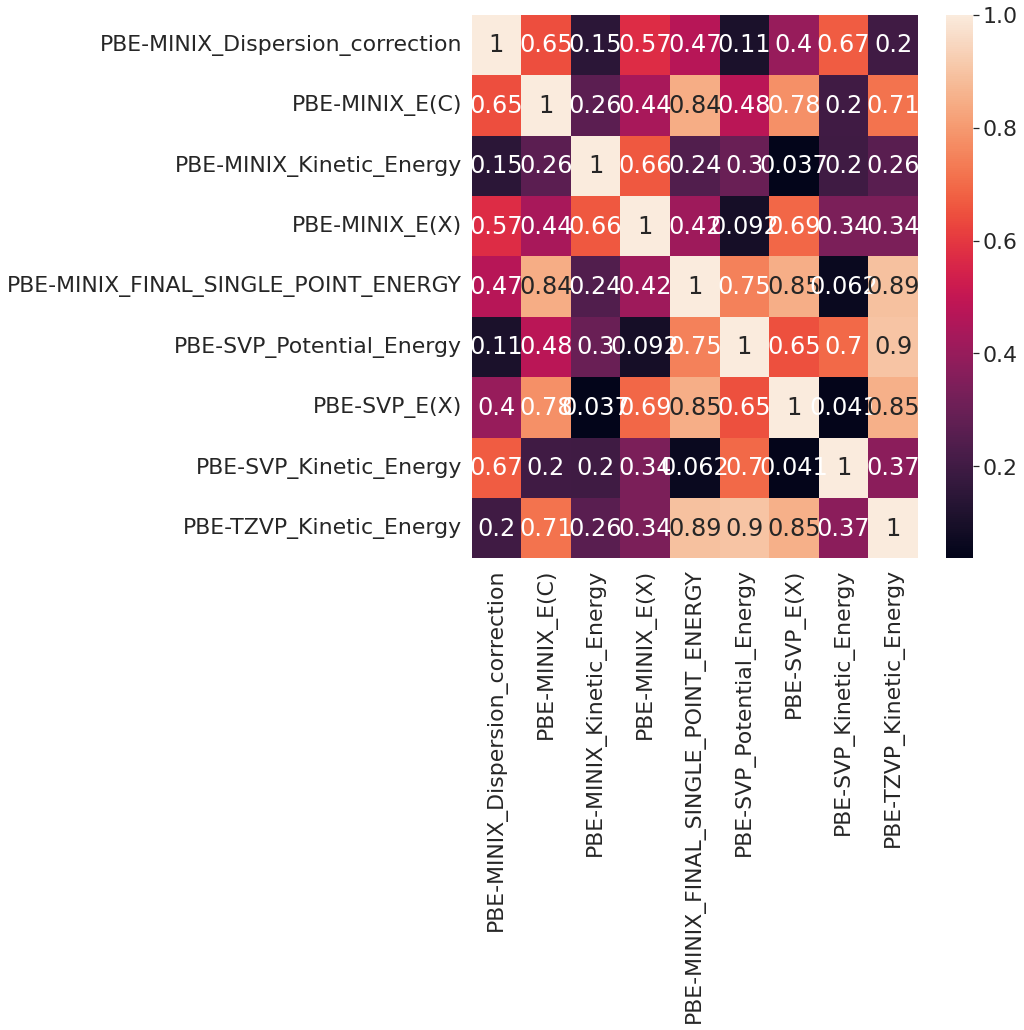

In [10]:
import seaborn as sns
%matplotlib inline
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 10,10
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [11]:
# CHECK WTAAD2 Calculation for reference methods (wtaad2_ref):
for setname in models_results:
    if setname in supersetnames:
        predicted = models_results[setname].y_pred_bestourmethod
        labels = models_results[setname].labels
        setlist = []
        for i, s in enumerate(models_results[setname].setname):
            ss = models_results[setname].supersetname[i]
            setlist.append(ss + "_" + s)   
        supersetlist = models_results[setname].supersetname

        wtmad = commonutils.wtmad_calc(supersetlist, setlist, predicted, labels, includeFull = False)
        print("WTMAD for ", setname, " and model ", \
              models_results[setname].bestourmethod, "\n")
        pp.pprint(wtmad)
        print(setname)

WTMAD for  BARRIER_HEIGHTS  and model  PBE0-TZVP 

{'BARRIER_HEIGHTS': numpy.float64(4.97)}
BARRIER_HEIGHTS
WTMAD for  INTRAMOLECULAR_INTERACTIONS  and model  PBE0-TZVP 

{'INTRAMOLECULAR_INTERACTIONS': numpy.float64(0.64)}
INTRAMOLECULAR_INTERACTIONS
WTMAD for  SMALL_MOLECULES  and model  PBE0-TZVP 

{'SMALL_MOLECULES': numpy.float64(10.14)}
SMALL_MOLECULES
WTMAD for  INTERMOLECULAR_INTERACTIONS  and model  TPSSh-TZVP 

{'INTERMOLECULAR_INTERACTIONS': numpy.float64(4.03)}
INTERMOLECULAR_INTERACTIONS
WTMAD for  LARGE_SYSTEMS  and model  PBE0-TZVP 

{'LARGE_SYSTEMS': numpy.float64(11.33)}
LARGE_SYSTEMS


In [12]:
# search for the best model a simple grid search
#nepochs = [50, 100]
nepochs = [100]
#batch_sizes = [4, 8, 16, 32]
batch_sizes = [16, 32]
#modelshapes = [[4, 4], [8, 8], [16, 16], \
#                [32, 32], [64, 64], [128, 128], \
#                [4, 4, 4], [8, 8, 8], [16, 16, 16], \
#                [32, 32, 32], [64, 64, 64], \
#                [128, 128, 128], [4, 4, 4, 4], \
#                [8, 8, 8, 8], [16, 16, 16, 16], \
#                [32, 32, 32, 32], [64, 64, 64, 64], \
#                [128, 128, 128, 128]]
modelshapes = [[4, 4, 4], [8, 8, 8], [16, 16, 16], \
                [32, 32, 32], [64, 64, 64], \
                [128, 128, 128], [4, 4, 4, 4], \
                [8, 8, 8, 8], [16, 16, 16, 16], \
                [32, 32, 32, 32], [64, 64, 64, 64], \
                [128, 128, 128, 128], [4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8], [16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32], [64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128], [4, 4, 4, 4, 4, 4], \
                [8, 8, 8, 8, 8, 8], [16, 16, 16, 16, 16, 16], 
                [32, 32, 32, 32, 32, 32], [64, 64, 64, 64, 64, 64],
                [128, 128, 128, 128, 128, 128]]
setname = "Full"
print("Searching for best NN model for set: ", setname)
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                            models_results[setname].labels)

setlist = []
for i, s in enumerate(models_results[setname].setname):
    ss = models_results[setname].supersetname[i]
    setlist.append(ss + "_" + s)   
supersetlist = models_results[setname].supersetname

scalerx = preprocessing.StandardScaler().fit(X)
X_s = scalerx.transform(X) 
scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))
Y_s = scalery.transform(Y.reshape(-1, 1))
modelminmape, modelminwtamd = \
        models.nn_model(0.2, X_s, scalerx, Y_s, scalery, \
            supersetlist, setlist, \
            nepochs, modelshapes, batch_sizes, inputshape=-1,\
            search=True, split=False)

print("Best NN model for set: ", setname, file=sys.stderr)
print("  WTAMD: ", modelminwtamd, file=sys.stderr)
print("   MAPE: ", modelminmape, file=sys.stderr)

models_results[setname].modelminmape = modelminmape
models_results[setname].modelminwtamd = modelminwtamd

Searching for best NN model for set:  Full
Progress: |██████████████████████████████████████████████████| 100.0% Complete


Best NN model for set:  Full
  WTAMD:  ([8, 8, 8, 8, 8], 100, 16)
   MAPE:  ([128, 128, 128], 100, 32)


In [13]:
import importlib
importlib.reload(models)

setname = "Full"

modelminmape = models_results[setname].modelminmape 
modelminwtamd = models_results[setname].modelminwtamd
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                models_results[setname].labels)

setlist = []
for i, s in enumerate(models_results[setname].setname):
    ss = models_results[setname].supersetname[i]
    setlist.append(ss + "_" + s)   
supersetlist = models_results[setname].supersetname

scalerx = preprocessing.StandardScaler().fit(X)
X_s = scalerx.transform(X) 
scalery = preprocessing.StandardScaler().fit(Y.reshape(-1, 1))
Y_s = scalery.transform(Y.reshape(-1, 1))
#build the final model and print the results
results_mape = models.nn_model(0.2, X_s, scalerx, Y_s, scalery, \
                    supersetlist, setlist, \
                    [modelminmape[1]], \
                    [modelminmape[0]], \
                    [modelminmape[2]], \
                    inputshape=-1,\
                    search=False, split=False)
        
models_results[setname].nn_model_mape = results_mape

results_wtamd = models.nn_model(0.2, X_s, scalerx, Y_s, scalery, \
                    supersetlist, setlist, \
                    [modelminwtamd[1]], \
                    [modelminwtamd[0]], \
                    [modelminwtamd[2]], \
                    inputshape=-1,\
                    search=False, split=False)
        
models_results[setname].nn_model_wtamd = results_wtamd

48/48 [==============================] - 0s 316us/step


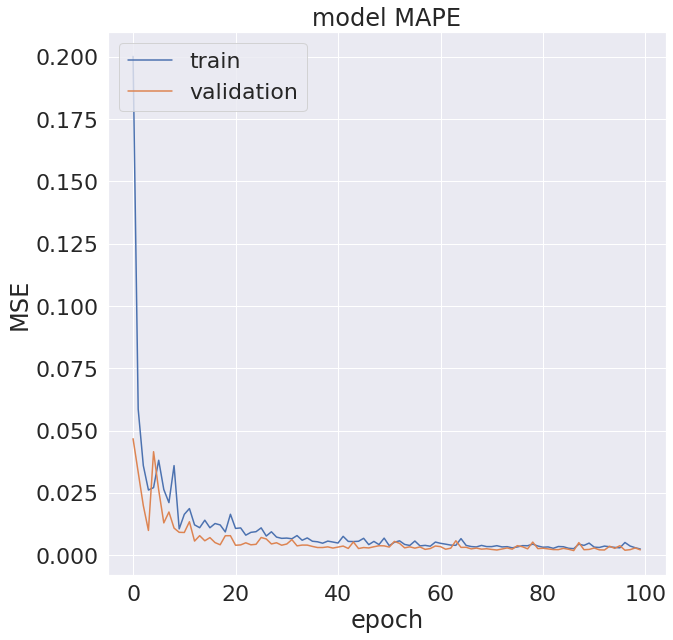

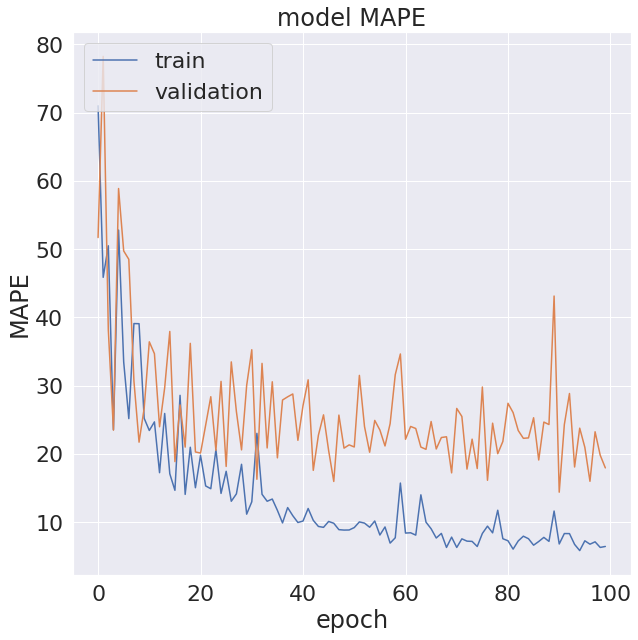

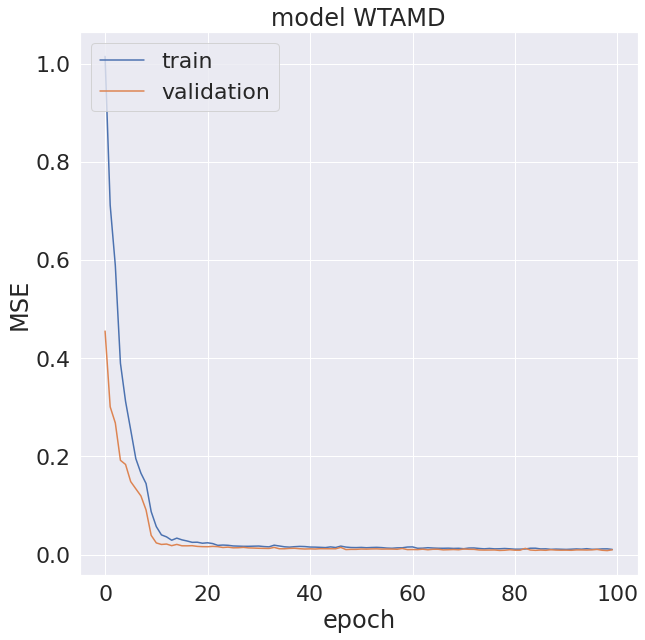

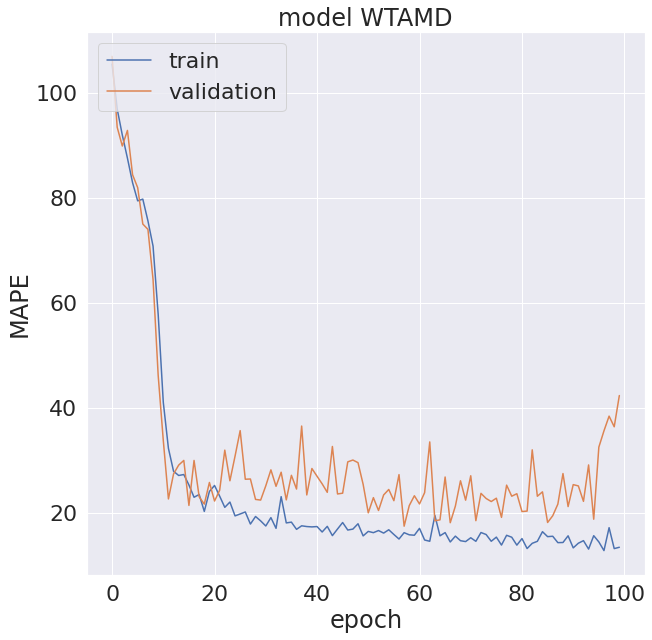

In [14]:
setname = "Full"
results_mape = models_results[setname].nn_model_mape
results_wtamd = models_results[setname].nn_model_wtamd
# summarize history for accuracy
history = results_mape['history']
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MAPE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model MAPE')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for accuracy
history = results_wtamd['history']
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model WTAMD')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model WTAMD')
plt.ylabel('MAPE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
#denomrlize the results
"""
plt.clf()
plt.scatter(results_mape['y_full'], \
            results_mape['y_pred_full'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
y_pred_full = scalery.inverse_transform(results_mape['y_pred_full'])
y_full = scalery.inverse_transform(results_mape['y_full'])
rmse_full = mean_squared_error(y_full, y_pred_full, squared=False)
r2_full = r2_score(y_full, y_pred_full)
print("RMSE Full      : %5.2f"%rmse_full)
print("R2 Full        : %5.2f"%r2_full)

# plot the results
plt.clf()
plt.scatter(y_full, y_pred_full)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#denomrlize the results
plt.clf()
plt.scatter(results_rmse['y_full'], \
            results_rmse['y_pred_full'])
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
y_pred_full = scalery.inverse_transform(results_rmse['y_pred_full'])
y_full = scalery.inverse_transform(results_rmse['y_full'])
rmse_full = mean_squared_error(y_full, y_pred_full, squared=False)
r2_full = r2_score(y_full, y_pred_full)
print("RMSE Full      : %5.2f"%rmse_full)
print("R2 Full        : %5.2f"%r2_full)

# plot the results
plt.clf()
plt.scatter(y_full, y_pred_full)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()
"""

'\nplt.clf()\nplt.scatter(results_mape[\'y_full\'],             results_mape[\'y_pred_full\'])\nplt.xlabel(\'True Values\')\nplt.ylabel(\'Predictions\')\nplt.show()\ny_pred_full = scalery.inverse_transform(results_mape[\'y_pred_full\'])\ny_full = scalery.inverse_transform(results_mape[\'y_full\'])\nrmse_full = mean_squared_error(y_full, y_pred_full, squared=False)\nr2_full = r2_score(y_full, y_pred_full)\nprint("RMSE Full      : %5.2f"%rmse_full)\nprint("R2 Full        : %5.2f"%r2_full)\n\n# plot the results\nplt.clf()\nplt.scatter(y_full, y_pred_full)\nplt.xlabel(\'True Values\')\nplt.ylabel(\'Predictions\')\nplt.show()\n\n#denomrlize the results\nplt.clf()\nplt.scatter(results_rmse[\'y_full\'],             results_rmse[\'y_pred_full\'])\nplt.xlabel(\'True Values\')\nplt.ylabel(\'Predictions\')\nplt.show()\ny_pred_full = scalery.inverse_transform(results_rmse[\'y_pred_full\'])\ny_full = scalery.inverse_transform(results_rmse[\'y_full\'])\nrmse_full = mean_squared_error(y_full, y_pred_

In [16]:
from sklearn.metrics import mean_absolute_percentage_error
setname = "Full"
results_mape = models_results[setname].nn_model_mape
results_wtamd = models_results[setname].nn_model_wtamd
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE Full mape, ", \
      "RMSE Full wtamd" )
for setname in fullsetnames:

    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))

    y_pred_mape = scalery.inverse_transform(results_mape['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred_mape = y_pred_mape
    rmse_mape = mean_squared_error(Y, y_pred_mape, squared=False)
    
    y_pred_wtamd = scalery.inverse_transform(results_wtamd['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred_wtamd = y_pred_wtamd
    rmse_wtamd = mean_squared_error(Y, y_pred_wtamd, squared=False)
    
    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse_mape, " , ", \
        "%7.3f"%rmse_wtamd)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE Full mape,  RMSE Full wtamd
 194 ,                          BARRIER_HEIGHTS  ,    8.201  ,    4.856  ,    3.028  ,    7.886
  76 ,                     BARRIER_HEIGHTS_BH76  ,   10.387  ,    5.505  ,    3.883  ,    8.765
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,    5.278  ,    3.036  ,    4.433
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,    3.762  ,    2.140  ,    4.820
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    0.718  ,    1.702  ,    2.792
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    1.534  ,    2.540  ,    7.879
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,    8.204  ,    2.595  ,   16.066
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,    5.887  ,    2.368  ,    4.539
 291 ,              INTRAMOLECULAR_INTERACTIONS  ,    0.873  ,    0.589  ,    1.732  ,    3.27

In [17]:
"""
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE , MAPE, R2")
for setname in fullsetnames:
    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    X_s = scalerx.transform(X)
    Y_s = scalery.transform(Y.reshape(-1, 1))
    y_pred = scalery.inverse_transform(results_rmse['model'].predict(X_s, verbose=0))
    models_results[setname].y_pred = y_pred
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    mape = mean_absolute_percentage_error(Y, y_pred)

    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%mape, " , ", \
        "%7.3f"%r2)
"""

'\nprint(" Dim , %40s"% "Dataset", " , ",       "Best inside method RMSE", " , ",       "Best our method RMSE", " , ",       "RMSE , MAPE, R2")\nfor setname in fullsetnames:\n    X, Y, features_names =             commonutils.build_XY_matrix (models_results[setname].fulldescriptors,                                     models_results[setname].labels)\n    \n    X_s = scalerx.transform(X)\n    Y_s = scalery.transform(Y.reshape(-1, 1))\n    y_pred = scalery.inverse_transform(results_rmse[\'model\'].predict(X_s, verbose=0))\n    models_results[setname].y_pred = y_pred\n    rmse = mean_squared_error(Y, y_pred, squared=False)\n    r2 = r2_score(Y, y_pred)\n    mape = mean_absolute_percentage_error(Y, y_pred)\n\n    print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ",         "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ",         "%7.3f"%models_results[setname].bestourmethod_rmse, " , ",         "%7.3f"%rmse, " , ",         "%7.3f"%mape, " , ",         "%7.

WTAMD2                      3.260
WTAMD2 (bestinsidemethod)   8.040
WTAMD2    (bestourmethod)   4.970
RMSE       (WTAMD full)   7.886
RMSE        (MAPE Full)   3.028
RMSE (bestinsidemethod)   8.201
RMSE    (bestourmethod)   4.856


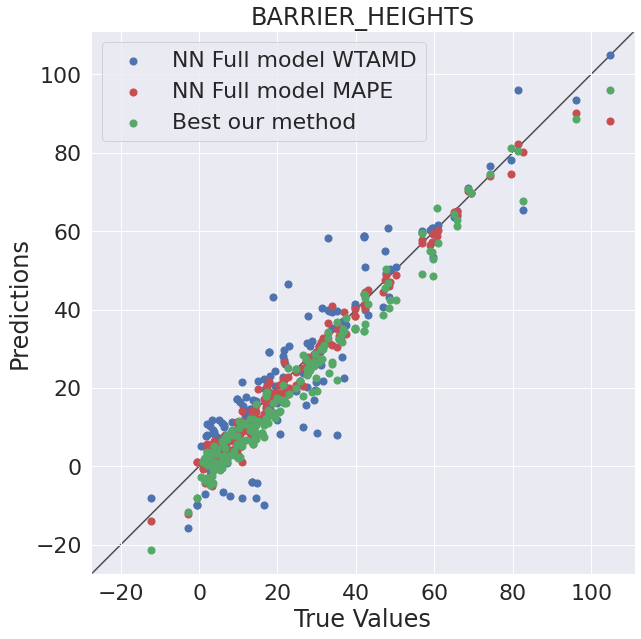

WTAMD2                      1.760
WTAMD2 (bestinsidemethod)   0.690
WTAMD2    (bestourmethod)   0.640
RMSE       (WTAMD full)   3.275
RMSE        (MAPE Full)   1.732
RMSE (bestinsidemethod)   0.873
RMSE    (bestourmethod)   0.589


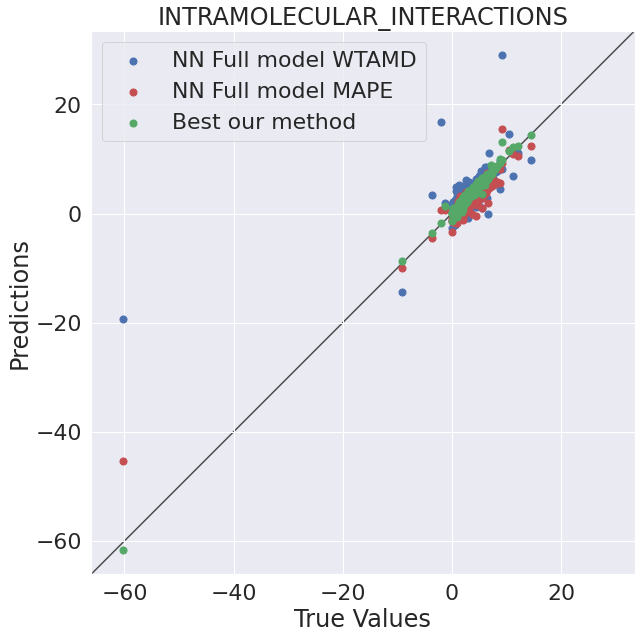

WTAMD2                     12.450
WTAMD2 (bestinsidemethod)  13.010
WTAMD2    (bestourmethod)  10.140
RMSE       (WTAMD full)  19.368
RMSE        (MAPE Full)   8.268
RMSE (bestinsidemethod)  12.191
RMSE    (bestourmethod)   6.291


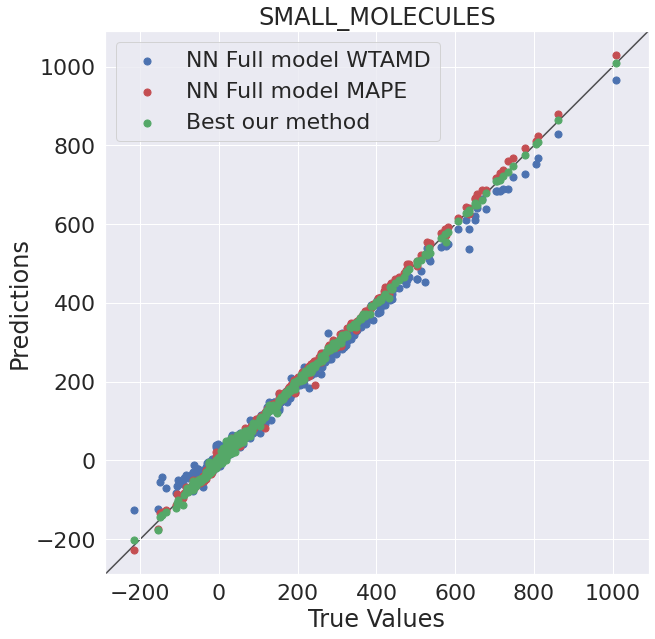

WTAMD2                      8.860
WTAMD2 (bestinsidemethod)   3.700
WTAMD2    (bestourmethod)   4.030
RMSE       (WTAMD full)  12.626
RMSE        (MAPE Full)   3.940
RMSE (bestinsidemethod)   2.286
RMSE    (bestourmethod)   5.970


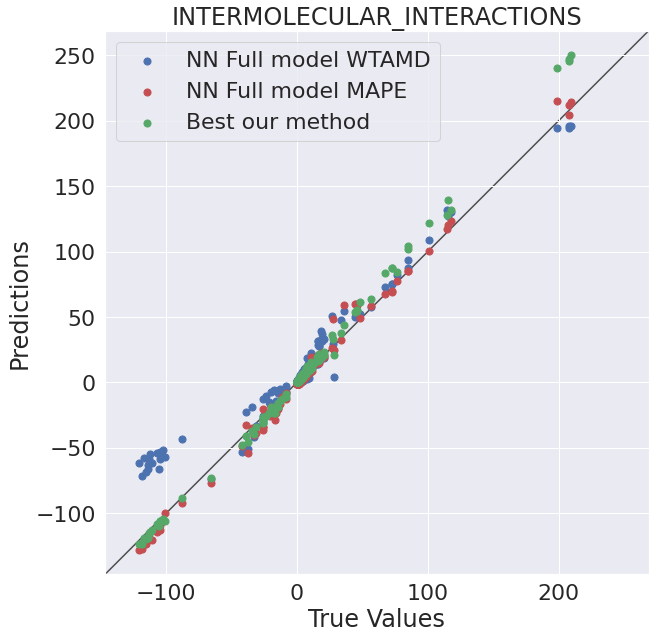

WTAMD2                     12.540
WTAMD2 (bestinsidemethod)  16.050
WTAMD2    (bestourmethod)  11.330
RMSE       (WTAMD full)  26.324
RMSE        (MAPE Full)  13.066
RMSE (bestinsidemethod)  12.567
RMSE    (bestourmethod)   9.042


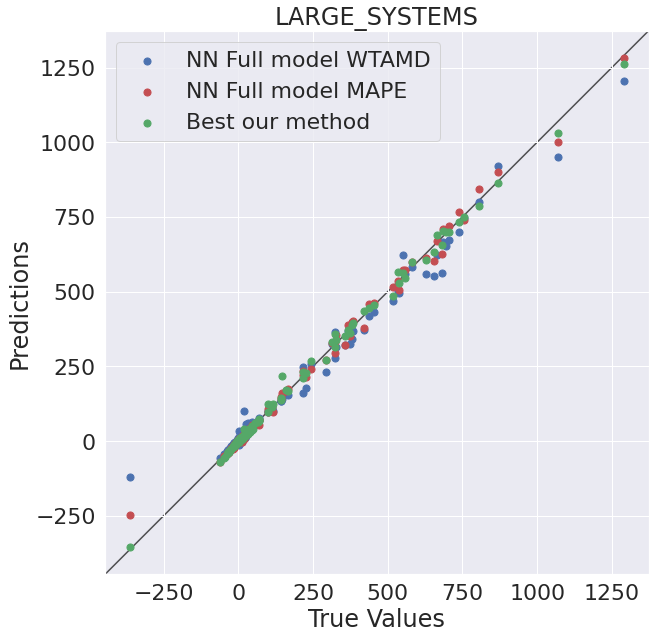

WTAMD2                     13.320
WTAMD2 (bestinsidemethod)  10.160
WTAMD2    (bestourmethod)   8.170
RMSE       (WTAMD full)  16.494
RMSE        (MAPE Full)   7.345
RMSE (bestinsidemethod)   9.227
RMSE    (bestourmethod)   6.219


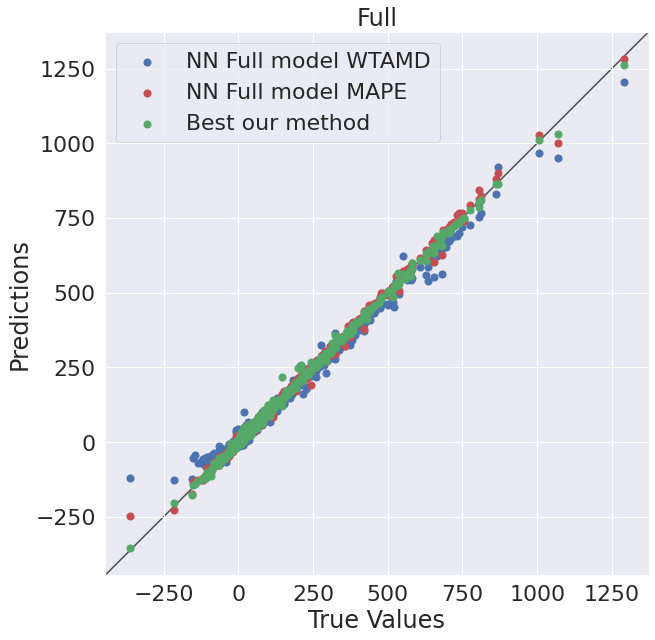

In [18]:
printonlysuperset = True

for setname in fullsetnames:
    ssetname = "Full"
    if setname in supersetnames or setname == "Full":
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]

    X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].fulldescriptors, \
                                    models_results[setname].labels)
    
    setlist = []
    for i, s in enumerate(models_results[setname].setname):
        ss = models_results[setname].supersetname[i]
        setlist.append(ss + "_" + s)   
    supersetlist = models_results[setname].supersetname
    
    y_pred_wtamd = models_results[setname].y_pred_wtamd 
    rmse_wtamd = mean_squared_error(Y, y_pred_wtamd, squared=False)
    y_pred_mape = models_results[setname].y_pred_mape
    rmse_mape = mean_squared_error(Y, y_pred_mape, squared=False)
    
    if setname in supersetnames or setname == "Full":
        wtmad2 = commonutils.wtmad_calc(supersetlist, setlist, y_pred_mape, \
                                      Y, includeFull = True)
        print("WTAMD2                    %7.3f"%wtmad2["Full"])
        print("WTAMD2 (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_wtamd) 
        print("WTAMD2    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_wtamd)

    if printonlysuperset and setname not in list(supersetnames.keys()) + ["Full"]:
        continue

    print("RMSE       (WTAMD full) %7.3f"%rmse_wtamd)
    print("RMSE        (MAPE Full) %7.3f"%rmse_mape)
    print("RMSE (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)


    fig, ax = plt.subplots()
    ax.scatter(Y, y_pred_wtamd, c='b', s=50, label='NN Full model WTAMD')
    ax.scatter(Y, y_pred_mape, \
                c='r', s=50, label='NN Full model MAPE')
    #ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
    #            c='r', s=50, label='Best inside method')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod, \
               c='g', s=50, label='Best our method')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()